In [1]:
# Import modules
import sys
sys.path.append('/mnt/e/')

import os
import geopandas as gpd
import pandas as pd
import GlacierClass as gc
import metrics as met
# import plotlib as gpl
import climate as clm
import climplotlib as cpl
# import utilities as utils
import plotutils as plu
import matplotlib.pyplot as plt
from shapely.ops import Point
import cartopy.crs as ccrs
import numpy as np
# import pwlf
# import matplotlib.ticker as mticker
# import rasterio as rio
# import matplotlib.colors as colors
# import matplotlib.cm as cm
import xarray as xr
import statsmodels.api as sm
from scipy import optimize

/home/taryn/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# User Parameters

# -- Glacier geodatabase
# ---- relative path for file geodatabase container glacier information
fgdb = '/mnt/e/northwest-decadal/gis-data/nwgreenland_decadal.gdb'
# ---- file geodatabase layer names
termini_layer = 'annual_termini'
points_layer = 'glacier_points'
boxes_layer = 'glacier_boxes'

# -- Climate directories and variables
ecco_sst_dir = '/mnt/e/data/ECCO-V5alpha/'
icesdk_file = '/mnt/e/data/ices_dk_NWGreenland_ocntemp/1118187b.csv'
hadley_sst_dir = '/mnt/e/data/hadley-oi/SST/'
ecco_sic_dir = '/mnt/e/data/ECCO_v5alpha/SIarea/'
hadley_sic_dir = '/mnt/e/data/hadley-oi/ICE/'
noaa_sic_dir = '/mnt/e/data/NSIDC_NOAA_G02202V3_monthly_sic/'
noaa_var = 'goddard_merged_seaice_conc_monthly'
mar_dir = '/mnt/e/data/MARv3.11/ERA_1979-2020-6km/'
fglacier_points = '/mnt/e/northwest-decadal/northwest_decadal_2021/glacier_points.csv'

# -- Other data files
oceanmask_file = '/mnt/e/data/GimpOceanMask_90m/GimpOceanMask_90m.shp'
bedmachine_file = '/mnt/e/data/BedMachineGreenland_v3/BedMachineGreenland_Bed250m.tif'
measures_file = '/mnt/e/data/MEaSUREs_Greenland_20yr_velocity_v1/greenland_vel_mosaic_v_v1_500m.tif'

# -- Relative path to save figure output
outpath = '/mnt/e/northwest-decadal/test/'

# -- Spatial bounds
ocean_bounds = [82, 68, -40, -76]
ice_bounds = [79, 68, -47, -74]
ocean_depth = 250
topo_range = [0, 1000]

# -- Temporal bounds
times = ['1972-09-01', '2020-08-31']

# -- Thresholds
sic_minimum = 15
ice_minimum = 90

# -- Discrete sampling points
ocean_points = [(69.00, -53.00),#(69.25, -52.25)
                (70.85, -54.25),
                (73.25, -58.00),
                (74.50, -60.00),
                (75.50, -62.00),#(75.70, -61.75)
                (75.75, -65.00),
                (76.25, -71.00),
                (77.00, -72.00)]#(77.00, -72.50)]
ocean_point_names = ['Disko Bay',
                     'Uummannaq Fjord',
                     'Upernavik Icefjord',
                     'South Melville Bay',
                     'Central Melville Bay',
                     'North Melville Bay',
                     'Wolstenholme Bay',
                     'Inglefield Fjord']
glacier_points = pd.read_csv(fglacier_points)
glacier_coords = [(glacier_points.iloc[g].Latitude, glacier_points.iloc[g].Longitude) for g in glacier_points.index]

# -- Geographic information (for plotting)
projection = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

# -- Select figure formatting style and set default figure properties
style = 'pub-cryo'
figformat = 'pdf'
figwidth = plu.figureWidth(style)
plu.globalDesignProperties(style)

In [3]:
# GLACIER DATA ANALYSIS

# -- Load glacier data
termini = gpd.read_file(fgdb, layer=termini_layer, driver='FileGDB')

points = gpd.read_file(fgdb, layer=points_layer, driver='FileGDB')
points.sort_values(by='Glacier_ID', inplace=True)
points.set_index('Glacier_ID', drop=False, inplace=True)

refboxes = gpd.read_file(fgdb, layer=boxes_layer, driver='FileGDB')
refboxes.sort_values(by='Glacier_ID', inplace=True)
refboxes.set_index('Glacier_ID', drop=False, inplace=True)

# -- Get scope of glaciers and time
GIDS = points.Glacier_ID.values

termini['Year'] = pd.to_datetime(termini['Year'], format='%Y')
YEAR_START = termini.Year.min().year
YEAR_END = termini.Year.max().year
YEARS = range(YEAR_START, YEAR_END)

DATE_START = termini.Source_Date.min()
DATE_END = termini.Source_Date.max()

# -- Initialize dictionary of Glacier objects to store glacier information
all_glaciers = {id: gc.Glacier(id) for id in GIDS}
for id in all_glaciers:
    all_glaciers[id].refbox = refboxes.loc[id].geometry
    all_glaciers[id].officialname = points.loc[id].Official_Name
    all_glaciers[id].greenlandicname = points.loc[id].Greenlandic_Name
    all_glaciers[id].alternativename = points.loc[id].Alternative_Name

# -- Construct an observation time series for each glacier
for id in GIDS:

    # get reference line and all observations for glacier ID
    glacier = termini.query('Glacier_ID == @id')
    # refbox = all_glaciers[id].refbox

    # loop through all observations and process data
    for n in range(len(glacier)):
        observation = glacier.iloc[n]

        # create a Terminus Observation for a row in geodataframe
        obs = gc.TerminusObservation(gid=int(observation.Glacier_ID),
                                     qflag=observation.Quality_Flag,
                                     termination='',
                                     imageid=observation.Image_ID,
                                     sensor=observation.Sensor,
                                     date=pd.to_datetime(
                                         observation.Source_Date),
                                     terminus=observation.geometry,
                                     referencebox=all_glaciers[id].refbox)

        # add glacier observation to time series
        all_glaciers[id].addObservation(obs)
    
    # update all attribute series for glacier
    all_glaciers[id].updateObservedValues()
    all_glaciers[id].updateDerivedValues(YEARS)

first_full_year = pd.to_datetime(str(met.firstFullYear(all_glaciers))+'-09')

In [4]:
# Load MAR data and resample, subset

mar_data = clm.loadData(mar_dir, dtype='mar')
mar = mar_data.resample(TIME='AS', keep_attrs=True).mean()
mar = clm.subsetGeographic(mar, ice_bounds, dtype='mar')
mar = clm.subsetIce(mar, threshold=ice_minimum)
mar = clm.subsetTopography(mar, topo_range, dtype='mar')

mar.SMB.load()
mar.SF.load()
mar.RU.load()

<xarray.DataArray 'RU' (TIME: 42, SECTOR1_1: 1, Y20_465: 196, X12_251: 66)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * TIME       (TIME) datetime64[ns] 1979-01-01 1980-01-01 ... 2020-01-01
  * X12_251    (X12_251) float32 -738.0 -732.0 -726.0 ... -360.0 -354.0 -348.0
  * Y20_465    (Y20_465) float32 -246.0 -240.0 -234.0 ... 1.056e+03 1.062e+03
  * SECTOR1_1  (SECTOR1_1) float32 1.0

In [5]:
# Load Ocean Temperature Data

# -- ECCO
ecco_sst = clm.loadData(ecco_sst_dir, dtype='ecco5')
ecco_sst = clm.subsetGeographic(ecco_sst, ocean_bounds, dtype='ecco5')
ecco_sst = clm.subsetTime(ecco_sst, times, dtype='ecco5')
ecco_sst_monthly = ecco_sst.resample(time='MS', keep_attrs=True).mean()
ecco_sst_monthly = clm.eccoTemperature(ecco_sst_monthly, dtype='ecco5')
ecco_sst = ecco_sst.resample(time='AS', keep_attrs=True).mean()
ecco_sst = clm.eccoTemperature(ecco_sst, dtype='ecco5')
ecco_sst.temperature.load()
ecco_sst_monthly.temperature.load()

# -- ICES-DK
icesdk_data = clm.loadData(icesdk_file, dtype='icesdk')
icesdk_data = clm.subsetGeographic(icesdk_data, ocean_bounds, dtype='icesdk')
icesdk_data = clm.subsetTime(icesdk_data, times, dtype='icesdk')

# -- Hadley-OI
hadley_sst = clm.loadData(hadley_sst_dir, dtype='hadley')
hadley_sst = clm.subsetGeographic(hadley_sst, ocean_bounds, dtype='hadley')
hadley_sst = clm.subsetTime(hadley_sst, times, dtype='hadley')
hadley_sst_monthly = hadley_sst.resample(time='MS', keep_attrs=True).mean()
hadley_sst = hadley_sst.resample(time='AS', keep_attrs=True).mean()
hadley_sst.SST.load()
hadley_sst_monthly.SST.load()

<xarray.DataArray 'SST' (time: 576, lat: 14, lon: 36)>
array([[[ 1.378     ,  0.28899992,  0.28899992, ...,  1.785     ,
          1.7163334 ,  1.6476667 ],
        [ 0.77900004,  0.77900004,  0.77900004, ...,  1.5916667 ,
          1.4907779 ,  1.3898889 ],
        [ 0.77900004,  1.8086666 ,  1.8086666 , ...,  1.5630952 ,
          1.4574444 ,  1.3517936 ],
        ...,
        [-0.74899995, -0.74899995, -0.74899995, ..., -0.16093515,
         -0.17765506, -0.19437495],
        [-0.74899995, -0.74899995, -0.74899995, ..., -0.9739629 ,
         -0.9826481 , -0.99133325],
        [-1.4596666 , -1.3745832 , -1.2895    , ..., -1.8       ,
         -1.8       , -1.8       ]],

       [[-0.65666664, -1.0426667 , -1.0426667 , ...,  0.93969226,
          0.9176409 ,  0.89558965],
        [-1.3933332 , -1.3933332 , -1.3933332 , ...,  0.7428889 ,
          0.68803704,  0.6331852 ],
        [-1.3933332 ,  1.052     ,  1.052     , ...,  1.119619  ,
          1.1275556 ,  1.1354921 ],
...
        [ 0.24741936,  0.24741936,  0.19608288, ...,  0.35404477,
          0.31153145,  0.26901817],
        [ 0.24741936,  0.24741936,  0.19608288, ...,  3.211732  ,
          3.3799427 ,  3.5481534 ],
        [ 1.4486173 ,  1.0322119 ,  0.6158064 , ...,  0.7234562 ,
          1.0694009 ,  1.4153455 ]],

       [[ 1.5884794 ,  1.5499997 ,  1.4947462 , ...,  5.2901206 ,
          4.9642096 ,  4.6382985 ],
        [ 1.5701383 ,  1.5701383 ,  1.5701383 , ...,  5.1599336 ,
          4.757165  ,  4.354396  ],
        [ 1.904055  ,  1.904055  ,  2.2934098 , ...,  5.6520605 ,
          5.3069887 ,  4.9619174 ],
        ...,
        [ 0.7943777 ,  0.7943777 ,  0.836728  , ...,  0.87591404,
          0.839063  ,  0.802212  ],
        [ 0.7943777 ,  0.7943777 ,  0.836728  , ...,  4.062555  ,
          4.30679   ,  4.551025  ],
        [ 2.082986  ,  1.8782581 ,  1.67353   , ...,  1.0146543 ,
          1.4765964 ,  1.9385384 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1972-09-01 1972-10-01 ... 2020-08-01
  * lon      (lon) float32 284.5 285.5 286.5 287.5 ... 316.5 317.5 318.5 319.5
  * lat      (lat) float32 68.5 69.5 70.5 71.5 72.5 ... 77.5 78.5 79.5 80.5 81.5

In [6]:
# Load Sea Ice Concentration Data

# -- Hadley-OI
hadley_sic = clm.loadData(hadley_sic_dir, dtype='hadley')
hadley_sic = clm.subsetGeographic(hadley_sic, ocean_bounds, dtype='hadley')
hadley_sic = clm.subsetTime(hadley_sic, times, dtype='hadley')
hadley_sic.SEAICE.load()

# -- NOAA
noaa_sic = clm.loadData(noaa_sic_dir, dtype='noaa')
noaa_sic = clm.subsetGeographic(noaa_sic, ocean_bounds, 'noaa')
noaa_sic = clm.subsetTime(noaa_sic, times, dtype='noaa')
noaa_sic[noaa_var].load()

<xarray.DataArray 'goddard_merged_seaice_conc_monthly' (time: 493, ygrid: 66, xgrid: 58)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
...
        ...,
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54],
        [ nan,  nan,  nan, ..., 2.54, 2.54, 2.54]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2019-12-01
  * ygrid      (ygrid) float32 -7.625e+05 -7.875e+05 ... -2.362e+06 -2.388e+06
  * xgrid      (xgrid) float32 -1.238e+06 -1.212e+06 ... 1.625e+05 1.875e+05
    latitude   (ygrid, xgrid) float64 76.64 76.83 77.03 ... 68.18 68.17 68.15
    longitude  (ygrid, xgrid) float64 -103.4 -102.8 -102.3 ... -41.11 -40.51
Attributes:
    valid_range:    [  0 100]
    long_name:      Goddard Edited Climate Data Record of Passive Microwave M...
    standard_name:  sea_ice_area_fraction
    units:          1
    flag_values:    [-5 -4 -3 -2 -1]
    flag_meanings:  pole_hole lakes coastal land_mask missing_data
    datum:          +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:   projection
    reference:      http://nsidc.org/data/nsidc-0051.html http://nsidc.org/da...

# Comparison of ocean data with Wood et al (2021)

In [7]:
wood_data = pd.read_csv('./wood2021_subset.csv')
wood_data = wood_data.iloc[0:6]
wood_data.set_index('Unnamed: 0', inplace=True)
wood_data.iloc[2:] = wood_data.iloc[2:].astype('float')

cw1 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'CW1']
cw2 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'CW2']
nw1 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'NW1']
nw2 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'NW2']
nw3 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'NW3']
nw4 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'NW4']
n1 = wood_data.loc[:, wood_data.loc['Ocean Model Sample Area'] == 'N1']
wood_pieces = [cw2, cw1, nw4, nw3, nw2, nw1, n1, n1]

cw1_dw = cw1.loc[:, cw1.loc['Categorization'] == 'DW']
cw2_dw = cw2.loc[:, cw2.loc['Categorization'] == 'DW']
nw1_dw = nw1.loc[:, nw1.loc['Categorization'] == 'DW']
nw2_dw = nw2.loc[:, nw2.loc['Categorization'] == 'DW']
nw3_dw = nw3.loc[:, nw3.loc['Categorization'] == 'DW']
nw4_dw = nw4.loc[:, nw4.loc['Categorization'] == 'DW']
n1_dw = n1.loc[:, n1.loc['Categorization'] == 'DW']
wood_pieces_dw = [cw2_dw, cw1_dw, nw4_dw, nw3_dw, nw2_dw, nw1_dw, n1_dw, n1_dw]

def plot_decadal_temperature_wood(ax, region):
    total_mean = region.loc['1992-2017'].mean()
    ax.hlines(region.loc['1992-1997'].mean() - total_mean, xmin=1992, xmax=1998, linewidth=5, alpha=0.7, color='dodgerblue', label='Wood regional average')
    ax.hlines(region.loc['1998-2007'].mean() - total_mean, xmin=1998, xmax=2008, linewidth=5, alpha=0.7, color='dodgerblue')
    ax.hlines(region.loc['2008-2017'].mean() - total_mean, xmin=2008, xmax=2018, linewidth=5, alpha=0.7, color='dodgerblue')

def plot_individual_glaciers_wood(ax, region):
    glacier_means = region.loc['1992-2017'].values
    ax.hlines(region.loc['1992-1997'].values - glacier_means, xmin=1992, xmax=1998, linewidth=1, alpha=0.2, color='dodgerblue', label='Wood individual glaciers')
    ax.hlines(region.loc['1998-2007'].values - glacier_means, xmin=1998, xmax=2008, linewidth=1, alpha=0.2, color='dodgerblue')
    ax.hlines(region.loc['2008-2017'].values - glacier_means, xmin=2008, xmax=2018, linewidth=1, alpha=0.2, color='dodgerblue')

def plot_decadal_temperature_ecco(ax, coordinate):
    ecco_deepwater = clm.selectPointData(data=ecco_sst, dtype='ecco5', coordinate=coordinate)
    ecco_depth = ecco_deepwater.sel(
        DEPTH_T=slice(ecco_deepwater.temperature.dropna(dim='DEPTH_T').DEPTH_T.max().values*0.4, ecco_deepwater.temperature.dropna(dim='DEPTH_T').DEPTH_T.max().values)
        ).temperature.mean(dim='DEPTH_T')
    total_mean = ecco_depth.sel(time=slice('1992-01-01', '2017-12-31')).mean().values
    ax.hlines(ecco_depth.sel(time=slice('1992-01-01', '1997-12-31')).mean().values - total_mean, xmin=1992, xmax=1998, linewidth=5, alpha=0.7, color='darkorange', label='ECCO deepest 60%')
    ax.hlines(ecco_depth.sel(time=slice('1998-01-01', '2007-12-31')).mean().values - total_mean, xmin=1998, xmax=2008, linewidth=5, alpha=0.7, color='darkorange')
    ax.hlines(ecco_depth.sel(time=slice('2008-01-01', '2017-12-31')).mean().values - total_mean, xmin=2008, xmax=2018, linewidth=5, alpha=0.7, color='darkorange')


# fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True, figsize=(6, 10))
# axs = axs.flatten()
# wood_pieces = [cw2, cw1, nw4, nw3, nw2, nw1, n1, n1]
# for coordinate in ocean_points:
#     nax = axs[ocean_points.index(coordinate)]
#     plot_decadal_temperature_wood(nax, wood_pieces[ocean_points.index(coordinate)])
#     plot_individual_glaciers_wood(nax, wood_pieces[ocean_points.index(coordinate)])
#     plot_decadal_temperature_ecco(nax, coordinate)
#     nax.set_ylabel('Temperature anomaly ($^oC$)')
#     nax.set_xlabel('Year')
#     nax.set_title('Ocean temperatures at {}'.format(ocean_point_names[ocean_points.index(coordinate)]))
#     nax.legend(loc='lower right', bbox_to_anchor=(0.99, 0.01))

# plt.savefig('{}ocean_temperature_comparison.png'.format(outpath), bbox_inches='tight', dpi=300)


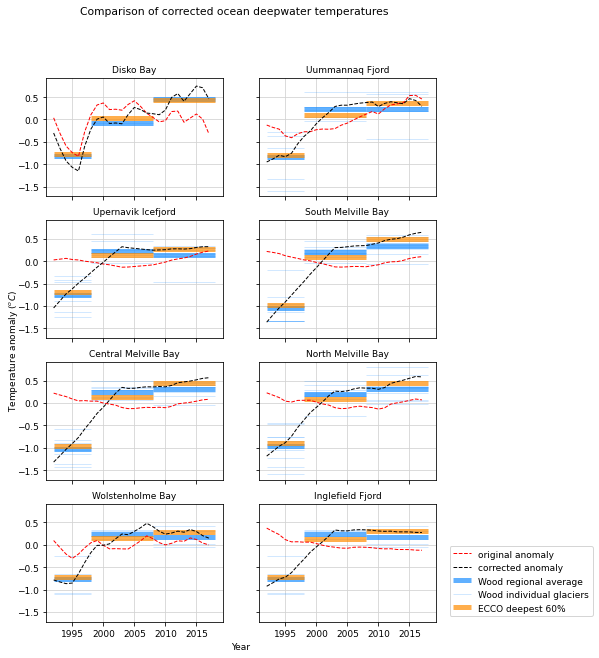

In [39]:
# derive a correction for each region to match Wood's numbers

def piecewise_linear(x, y0, k1, k2):
    '''Piecewise linear function that breaks at x0=2003'''
    x0 = 2003.
    return np.piecewise(x, [x < x0], [lambda x: k1*x + y0 - k1*x0, lambda x: k2*x + y0 - k2*x0])


def regional_correction(coordinate, wood_data, ecco_data):
    # -- Get data for curve fit
    years = np.array([1995., 2003., 2013.])
    wood_total_mean = wood_data.loc['1992-2017'].mean()
    wood = np.array([
        wood_data.loc['1992-1997'].mean() - wood_total_mean, 
        wood_data.loc['1998-2007'].mean() - wood_total_mean, 
        wood_data.loc['2008-2017'].mean() - wood_total_mean])
    mine_total_mean = ecco_data.sel(time=slice('1992-01-01', '2017-12-31')).mean().values
    mine = np.array([
        float(ecco_data.sel(time=slice('1992-01-01', '1997-12-31')).mean().values - mine_total_mean), 
        float(ecco_data.sel(time=slice('1998-01-01', '2007-12-31')).mean().values - mine_total_mean), 
        float(ecco_data.sel(time=slice('2008-01-01', '2017-12-31')).mean().values - mine_total_mean)])
    diff = mine - wood
    # -- fit curve to data (difference between my data and wood's)
    p, e = optimize.curve_fit(piecewise_linear, years, diff)

    return p


def plot_decadal_temperature_ecco_bias_corrected(ax, coordinate, ecco_data, wood_data):
# -- get ECCO data at point for bottom 60% of water column
    ecco_deepwater = clm.selectPointData(data=ecco_data, dtype='ecco5', coordinate=coordinate)
    ecco_depth = ecco_deepwater.sel(
        DEPTH_T=slice(
            ecco_deepwater.temperature.dropna(dim='DEPTH_T').DEPTH_T.max().values*0.4, 
            ecco_deepwater.temperature.dropna(dim='DEPTH_T').DEPTH_T.max().values)
        ).temperature.mean(dim='DEPTH_T')
    # -- apply regional correction (piecewise linear fit)
    p = regional_correction(coordinate, wood_data, ecco_depth)  
    # -- use regional correction to calculate corrected ECCO temperature anomaly
    years_all = pd.to_datetime(ecco_depth.time).year.astype('float')
    correction = piecewise_linear(years_all, *p)
    ecco_depth_bias_corrected = ecco_depth - correction
    total_mean = ecco_depth_bias_corrected.sel(time=slice('1992-01-01', '2017-12-31')).mean().values
    ecco_depth_bias_corrected_anomaly = ecco_depth_bias_corrected - total_mean
    # -- plot ECCO decadal corrected temperature anomalies
    ax.plot(pd.to_datetime(ecco_depth.time).year, ecco_depth - ecco_depth.mean(), '--r', label='original anomaly')
    ax.plot(pd.to_datetime(ecco_depth_bias_corrected_anomaly.time).year, ecco_depth_bias_corrected_anomaly, '--k', label='corrected anomaly')
    ax.hlines(ecco_depth_bias_corrected_anomaly.sel(
        time=slice('1992-01-01', '1997-12-31')).mean().values, 
        xmin=1992., xmax=1998., linewidth=5, alpha=0.7, color='darkorange', label='ECCO deepest 60%')
    ax.hlines(ecco_depth_bias_corrected_anomaly.sel(
        time=slice('1998-01-01', '2007-12-31')).mean().values, 
        xmin=1998., xmax=2008., linewidth=5, alpha=0.7, color='darkorange')
    ax.hlines(ecco_depth_bias_corrected_anomaly.sel(
        time=slice('2008-01-01', '2017-12-31')).mean().values, 
        xmin=2008., xmax=2018., linewidth=5, alpha=0.7, color='darkorange')


# idx = 0
# coordinate = ocean_points[idx]
# wood_piece = wood_pieces_dw[idx]

# fig, ax = plt.subplots()
# plot_decadal_temperature_wood(ax, wood_piece)
# plot_decadal_temperature_ecco_bias_corrected(ax, coordinate, ecco_sst, wood_piece)

fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True, figsize=(7, 10))
axs = axs.flatten()
# wood_pieces = [cw2, cw1, nw4, nw3, nw2, nw1, n1, n1]
wood_pieces_dw = [cw2_dw, cw1_dw, nw4_dw, nw3_dw, nw2_dw, nw1_dw, n1_dw, n1_dw]
for coordinate in ocean_points:
    nax = axs[ocean_points.index(coordinate)]
    wood_piece = wood_pieces_dw[ocean_points.index(coordinate)]
    plot_decadal_temperature_wood(nax, wood_piece)
    plot_individual_glaciers_wood(nax, wood_piece)
    plot_decadal_temperature_ecco_bias_corrected(nax, coordinate, ecco_sst, wood_piece)
    # nax.set_ylabel('Temperature anomaly ($^oC$)')
    # nax.set_xlabel('Year')
    nax.set_title('{}'.format(ocean_point_names[ocean_points.index(coordinate)]))
    if ocean_points.index(coordinate) == 7:
        nax.legend(loc='lower left', bbox_to_anchor=(1.05, 0.01))

cpl.subplotGridLabels(
    fig, 
    title='Comparison of corrected ocean deepwater temperatures', 
    ylabel='Temperature anomaly ($^oC$)', 
    xlabel='Year')

plt.savefig('{}suppfig5_ocean_temperature_corrected.png'.format(outpath), bbox_inches='tight', dpi=300)
plt.savefig('{}suppfig5_ocean_temperature_corrected.pdf'.format(outpath), bbox_inches='tight', dpi=300)

# Create data table for multiple linear regressions

In [9]:
vars_list = ['ECCO_depth', 'ECCO_SST', 'Hadley_SST', 'Mean_SST', 'Mean_Temp', 'Hadley_SISL', 'NOAA_SISL', 'Mean_SISL', 'Hadley_ASIC', 'NOAA_ASIC', 'Mean_ASIC', 'SMB', 'Snowfall', 'Runoff']
X = pd.DataFrame(columns=vars_list)
Y = []

wood_data = wood_pieces_dw

for coordinate in ocean_points:
    idx = ocean_points.index(coordinate)
    # Get mean glacier length trend for ocean zone
    zone_gids = glacier_points[glacier_points.Ocean == idx+1].GID
    zone_glaciers = met.filterGlaciers(all_glaciers, zone_gids.values, idtype='keep')
    zone_lengths = pd.DataFrame(index=zone_gids.values, columns=zone_glaciers[list(zone_glaciers.keys())[0]].interplengths.index, data=[zone_glaciers[x].interplengths.values.flatten() for x in zone_glaciers])
    zone_annual_length_change = zone_lengths.mean().diff()
    zone_annual_length_change_filter = zone_annual_length_change[zone_annual_length_change.index >= 1992]
    zone_annual_length_change_filter = zone_annual_length_change_filter[zone_annual_length_change_filter.index <= 2017]
    Y.extend(zone_annual_length_change_filter.values)

    # Get MAR data for glacier zones
    zone_glacier_coords = [glacier_coords[x] for x in zone_gids.index]
    # -- SMB
    zone_anom_SMB = clm.bulkAnomalyMAR(mar, zone_glacier_coords, 'SMB')
    zone_mean_anom_SMB = zone_anom_SMB.mean()
    zone_mean_anom_SMB = zone_mean_anom_SMB[zone_mean_anom_SMB.index >= pd.to_datetime('1992-01-01')]
    zone_mean_anom_SMB = zone_mean_anom_SMB[zone_mean_anom_SMB.index <= pd.to_datetime('2017-01-01')]
    # -- Snowfall
    zone_anom_SF = clm.bulkAnomalyMAR(mar, zone_glacier_coords, 'SF')
    zone_mean_anom_SF = zone_anom_SF.mean()
    zone_mean_anom_SF = zone_mean_anom_SF[zone_mean_anom_SF.index >= pd.to_datetime('1992-01-01')]
    zone_mean_anom_SF = zone_mean_anom_SF[zone_mean_anom_SF.index <= pd.to_datetime('2017-01-01')]
    # -- Runoff
    zone_anom_RU = clm.bulkAnomalyMAR(mar, zone_glacier_coords, 'RU')
    zone_mean_anom_RU = zone_anom_RU.mean()
    zone_mean_anom_RU = zone_mean_anom_RU[zone_mean_anom_RU.index >= pd.to_datetime('1992-01-01')]
    zone_mean_anom_RU = zone_mean_anom_RU[zone_mean_anom_RU.index <= pd.to_datetime('2017-01-01')]

    # Get climate data for ocean zone
    # -- ECCO deepwater (bottom 60%) mean temperature with Wood biases applied and regional corrections to match Wood
    wood_piece = wood_data[idx]
    ecco_deepwater = clm.selectPointData(data=ecco_sst, dtype='ecco5', coordinate=coordinate)
    ecco_depth = ecco_deepwater.sel(
        DEPTH_T=slice(
            ecco_deepwater.temperature.dropna(dim='DEPTH_T').DEPTH_T.max().values*0.4, 
            ecco_deepwater.temperature.dropna(dim='DEPTH_T').DEPTH_T.max().values)
        ).temperature.mean(dim='DEPTH_T')
    # -- apply regional correction (piecewise linear fit)
    p = regional_correction(coordinate, wood_piece, ecco_depth)
    years = pd.to_datetime(ecco_depth.time).year.astype('float')
    correction = piecewise_linear(years, *p)
    ecco_depth_bias_corrected = ecco_depth - correction
    total_mean = ecco_depth_bias_corrected.sel(time=slice('1992-01-01', '2017-12-31')).mean().values
    ecco_depth_bias_corrected_anomaly = ecco_depth_bias_corrected - total_mean
    
    # -- ECCO SST
    ecco_surface = clm.selectPointData(ecco_sst, dtype='ecco5', depth=0, coordinate=coordinate).temperature
    # -- Hadley SST
    hadley_surface = clm.selectPointData(hadley_sst, dtype='hadley', coordinate=coordinate).SST
    hadley_surface = hadley_surface[hadley_surface.time >= pd.to_datetime('1992-01-01')]
    hadley_surface = hadley_surface[hadley_surface.time <= pd.to_datetime('2017-01-01')]
    # -- Mean SST
    mean_surface = (ecco_surface + hadley_surface)/2
    # -- Mean ocean temperature
    mean_temp = (ecco_depth + mean_surface)/2
    # -- Hadley sea ice season length
    hadley_sisl = clm.seaIceSeasonLength(hadley_sic, 'SEAICE', dtype='hadley', minimum=sic_minimum, coordinate=coordinate)
    hadley_sisl = hadley_sisl[hadley_sisl.time >= pd.to_datetime('1991-01-01')]
    hadley_sisl = hadley_sisl[hadley_sisl.time <= pd.to_datetime('2017-01-01')]
    # -- NOAA sea ice season length
    noaa_sisl = clm.seaIceSeasonLength(noaa_sic, noaa_var, dtype='noaa', minimum=sic_minimum, coordinate=coordinate)
    noaa_sisl = noaa_sisl[noaa_sisl.time >= pd.to_datetime('1991-01-01')]
    noaa_sisl = noaa_sisl[noaa_sisl.time <= pd.to_datetime('2017-01-01')]
    # -- Mean sea ice season length
    mean_sisl = (hadley_sisl + noaa_sisl)/2
    # -- Hadley mean annual sea ice concentration
    hadley_asic = clm.selectPointData(hadley_sic, dtype='hadley', coordinate=coordinate)
    hadley_asic = hadley_asic.resample(time='AS').mean().SEAICE    
    hadley_asic = hadley_asic[hadley_asic.time >= pd.to_datetime('1992-01-01')]
    hadley_asic = hadley_asic[hadley_asic.time <= pd.to_datetime('2017-01-01')]
    # -- NOAA mean annual sea ice concentration
    noaa_asic = clm.selectPointData(noaa_sic, dtype='noaa', coordinate=coordinate)
    noaa_asic = noaa_asic.resample(time='AS').mean()[noaa_var]    
    noaa_asic = noaa_asic[noaa_asic.time >= pd.to_datetime('1992-01-01')]
    noaa_asic = noaa_asic[noaa_asic.time <= pd.to_datetime('2017-01-01')]
    noaa_asic = noaa_asic * 100
    # -- Mean mean annual sea ice concentration
    mean_asic = (hadley_asic + noaa_asic)/2

    climate_data = pd.DataFrame(data=[ecco_depth_bias_corrected_anomaly.values, ecco_surface.values, hadley_surface.values, mean_surface.values, mean_temp.values, hadley_sisl.values, noaa_sisl.values, mean_sisl.values, hadley_asic.values, noaa_asic.values, mean_asic.values, zone_mean_anom_SMB.values, zone_mean_anom_SF.values, zone_mean_anom_RU.values]).transpose().rename(columns={0: 'ECCO_depth', 1: 'ECCO_SST', 2: 'Hadley_SST', 3: 'Mean_SST', 4: 'Mean_Temp', 5: 'Hadley_SISL', 6: 'NOAA_SISL', 7: 'Mean_SISL', 8: 'Hadley_ASIC', 9: 'NOAA_ASIC', 10: 'Mean_ASIC', 11: 'SMB', 12: 'Snowfall', 13: 'Runoff'})
    
    X = X.append(climate_data)

X


,ECCO_depth,ECCO_SST,Hadley_SST,Mean_SST,Mean_Temp,Hadley_SISL,NOAA_SISL,Mean_SISL,Hadley_ASIC,NOAA_ASIC,Mean_ASIC,SMB,Snowfall,Runoff
0,-0.305149,-0.710124,0.230972,-0.239576,1.358917,6.0,7.0,6.5,39.666668,43.583332,41.625000,1.405736,-0.020657,-1.470766
1,-0.641381,0.422287,0.297607,0.359947,1.488934,5.0,7.0,6.0,39.166668,44.916664,42.041664,-0.150615,-0.059560,0.109222
2,-0.928120,0.279228,0.365452,0.322340,1.325132,6.0,6.0,6.0,36.500000,42.999996,39.750000,0.110094,-0.023836,-0.123166
3,-1.072366,1.030626,0.666801,0.848713,1.514567,5.0,7.0,6.0,30.583334,38.250004,34.416668,-0.567572,-0.048316,0.497577
4,-1.153645,0.596595,0.884159,0.740377,1.418131,5.0,9.0,7.0,29.250000,47.083328,38.166664,0.534904,0.102300,-0.488453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,0.288684,-0.728937,-0.302112,-0.515525,-0.470662,10.0,8.0,9.0,45.583332,52.333336,48.958336,0.287518,0.104359,-0.199719
22,0.289229,-0.995672,-0.143426,-0.569549,-0.497799,11.0,8.0,9.5,42.250000,46.083336,44.166668,-0.249601,-0.068821,0.219337
23,0.288273,-1.068604,-0.432342,-0.750473,-0.589136,10.0,8.0,9.0,46.916668,51.333332,49.125000,-0.669531,-0.096446,0.550667
24,0.276878,-0.698580,-0.154162,-0.426371,-0.433180,11.0,7.0,9.0,40.750000,42.083332,41.416664,-0.093802,0.071879,0.351038


# Covariance matrix

In [10]:
x = X.to_numpy()
m_covariance = np.cov(x, rowvar=False)
m_covariance = pd.DataFrame(data=m_covariance, columns=vars_list, index=vars_list)
m_covariance

,ECCO_depth,ECCO_SST,Hadley_SST,Mean_SST,Mean_Temp,Hadley_SISL,NOAA_SISL,Mean_SISL,Hadley_ASIC,NOAA_ASIC,Mean_ASIC,SMB,Snowfall,Runoff
ECCO_depth,0.258750,0.114764,0.146563,0.130664,0.069675,-0.204189,-0.439717,-0.321953,-2.635558,-3.641359,-3.138458,-0.114544,-0.005185,0.117815
ECCO_SST,0.114764,0.668551,0.610379,0.639465,0.621298,-0.712885,-0.919928,-0.816407,-9.057739,-10.923773,-9.990756,-0.120589,-0.003096,0.123820
Hadley_SST,0.146563,0.610379,0.811631,0.711005,0.715849,-0.860127,-0.965574,-0.912851,-10.897635,-12.068516,-11.483075,-0.097652,-0.003777,0.102647
Mean_SST,0.130664,0.639465,0.711005,0.675235,0.668573,-0.786506,-0.942751,-0.864629,-9.977687,-11.496145,-10.736916,-0.109121,-0.003436,0.113234
Mean_Temp,0.069675,0.621298,0.715849,0.668573,0.786114,-0.860745,-0.935177,-0.897961,-8.634496,-10.249098,-9.441797,-0.059800,0.000517,0.064106
Hadley_SISL,-0.204189,-0.712885,-0.860127,-0.786506,-0.860745,2.995703,1.633315,2.314509,14.798341,13.489304,14.143822,0.131583,-0.000981,-0.142705
NOAA_SISL,-0.439717,-0.919928,-0.965574,-0.942751,-0.935177,1.633315,3.066146,2.349731,15.501959,21.181607,18.341783,0.286361,0.019005,-0.285406
Mean_SISL,-0.321953,-0.816407,-0.912851,-0.864629,-0.897961,2.314509,2.349731,2.332120,15.150150,17.335455,16.242803,0.208972,0.009012,-0.214055
Hadley_ASIC,-2.635558,-9.057739,-10.897635,-9.977687,-8.634496,14.798341,15.501959,15.150150,199.615064,203.941013,201.778038,2.098591,0.122450,-2.180270
NOAA_ASIC,-3.641359,-10.923773,-12.068516,-11.496145,-10.249098,13.489304,21.181607,17.335455,203.941013,245.590935,224.765974,3.077876,0.230596,-3.095412


# Ocean Temperatures

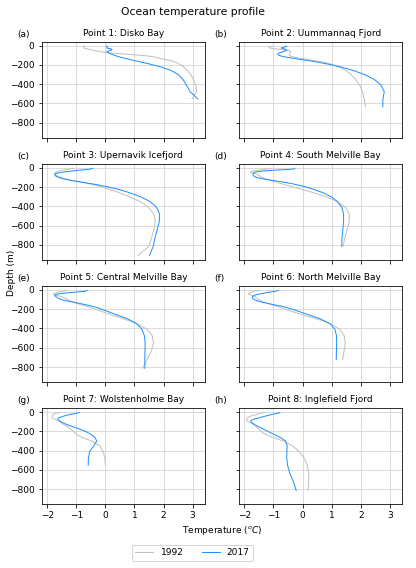

In [11]:
fig, axs = plt.subplots(
    nrows=4, ncols=2,
    sharex=True, sharey=True,
    figsize=(figwidth*2, figwidth*2.5))
axs = axs.flatten()
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

for coordinate in ocean_points:
    nax = axs[ocean_points.index(coordinate)]
    ecco_profile = clm.selectPointData(data=ecco_sst, dtype='ecco5', coordinate=coordinate)
    ecco_depth_profile_first = ecco_profile.sel(time='1992-01-01')
    ecco_depth_profile_last = ecco_profile.sel(time='2017-01-01')
    nax.plot(ecco_depth_profile_first.temperature, -ecco_depth_profile_first.DEPTH_T, color='silver', label='1992')
    nax.plot(ecco_depth_profile_last.temperature, -ecco_depth_profile_last.DEPTH_T, color='dodgerblue', label='2017')
    nax.set_title('Point {}: {}'.format(
        ocean_points.index(coordinate)+1,
        ocean_point_names[ocean_points.index(coordinate)]))
    nax.set_xticks([-2, -1, 0, 1, 2, 3])
    label = labels[ocean_points.index(coordinate)]
    nax.annotate(text=label, xy=(-0.15, 1.05), xycoords='axes fraction')

handles = nax.get_legend_handles_labels()
labels = handles[1]
fig.legend(handles=handles[0], labels=labels, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 0.04))
cpl.subplotGridLabels(
    fig,
    title='Ocean temperature profile',
    ylabel='Depth (m)',
    xlabel='Temperature ($^oC$)')

plt.tight_layout()

plt.savefig('{}ocean_temperature_profiles.png'.format(outpath), bbox_inches='tight', dpi=300)

# SST by month

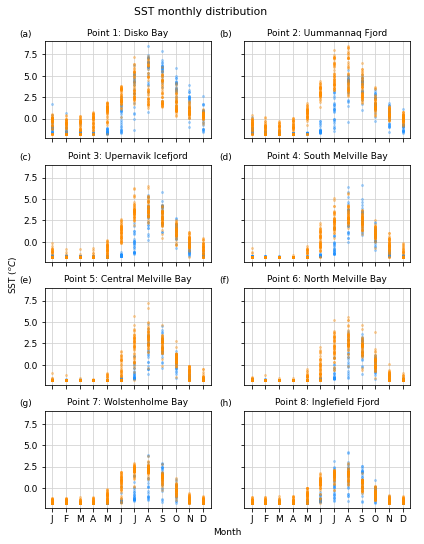

In [12]:
fig, axs = plt.subplots(
    nrows=4, ncols=2,
    sharex=True, sharey=True,
    figsize=(figwidth*2, figwidth*2.5))
axs = axs.flatten()
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

for coordinate in ocean_points:
    nax = axs[ocean_points.index(coordinate)]
    ecco_sst_point = clm.selectPointData(data=ecco_sst_monthly, dtype='ecco5', depth=0, coordinate=coordinate)
    hadley_sst_point = clm.selectPointData(data=hadley_sst_monthly, dtype='hadley', coordinate=coordinate)
    nax.scatter(pd.to_datetime(ecco_sst_point.time.values).month, ecco_sst_point.temperature.values, color='dodgerblue', alpha=0.3)
    nax.scatter(pd.to_datetime(hadley_sst_point.time.values).month, hadley_sst_point.SST.values, color='darkorange', alpha=0.3)
    nax.set_title('Point {}: {}'.format(
        ocean_points.index(coordinate)+1,
        ocean_point_names[ocean_points.index(coordinate)]))
    nax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    nax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    label = labels[ocean_points.index(coordinate)]
    nax.annotate(text=label, xy=(-0.15, 1.05), xycoords='axes fraction')

cpl.subplotGridLabels(
    fig,
    title='SST monthly distribution',
    ylabel='SST ($^oC$)',
    xlabel='Month')

plt.tight_layout()

plt.savefig('{}monthly_sst.png'.format(outpath), bbox_inches='tight', dpi=300)

# Linear Regressions

In [13]:
def linreg(x, y):
    results = sm.OLS(y, sm.add_constant(x)).fit()
    print(results.summary())
    return results

def plotLinReg(ax, x, y, dataname):
    # compute linear regression
    results = linreg(x, y)
    # plot raw data
    ax.scatter(x, y, label=dataname+' data')
    # plot regression line
    x_pred = np.linspace([ax.get_xbound()[0]], [ax.get_xbound()[1]], 10)
    y_pred = results.params[0] + results.params[1]*x_pred
    ax.plot(x_pred, y_pred, '--', label=dataname+f' linear regression\n($slope={results.params[1]:.3f}, R^2={results.rsquared:.3f}, p={results.pvalues[1]:.2E}, se={results.bse[1]:.3f}$)')
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Single linear regressions

### Between certain variables

                            OLS Regression Results                            
Dep. Variable:               ECCO_SST   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     16.98
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           5.48e-05
Time:                        16:31:25   Log-Likelihood:                -244.53
No. Observations:                 208   AIC:                             493.1
Df Residuals:                     206   BIC:                             499.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4398      0.055     -8.051      0.0

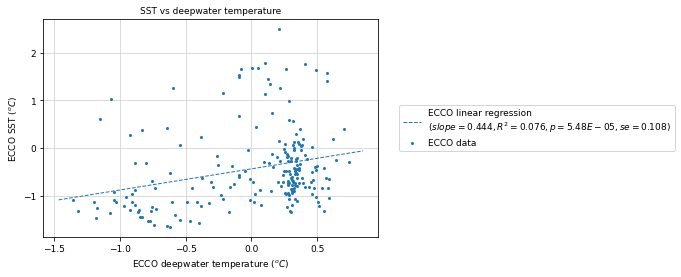

In [14]:
# SST vs 250m temperature
x = X['ECCO_depth']
y = X['ECCO_SST']

fig, ax = plt.subplots()
plotLinReg(ax, x, y, dataname='ECCO')
ax.set_xlabel('ECCO deepwater temperature ($^oC$)')
ax.set_ylabel('ECCO SST ($^oC$)')
ax.set_title('SST vs deepwater temperature')
plt.show()

                            OLS Regression Results                            
Dep. Variable:               ECCO_SST   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     328.7
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           1.51e-44
Time:                        16:31:26   Log-Likelihood:                -153.56
No. Observations:                 208   AIC:                             311.1
Df Residuals:                     206   BIC:                             317.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.7492      0.126     13.907      

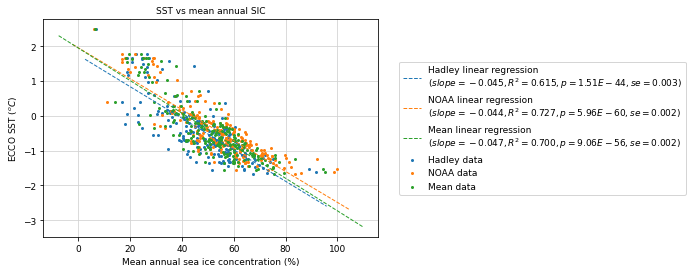

In [15]:
# SST vs sea ice concentration
y = X['ECCO_SST']

fig, ax = plt.subplots()

x = X['Hadley_ASIC']
plotLinReg(ax, x, y, dataname='Hadley')

x = X['NOAA_ASIC']
plotLinReg(ax, x, y, dataname='NOAA')

x = X['Mean_ASIC']
plotLinReg(ax, x, y, dataname='Mean')

ax.set_xlabel('Mean annual sea ice concentration (%)')
ax.set_ylabel('ECCO SST ($^oC$)')
ax.set_title('SST vs mean annual SIC')
plt.show()

### Against retreat

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     17.54
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           4.16e-05
Time:                        16:31:26   Log-Likelihood:                 60.700
No. Observations:                 208   AIC:                            -117.4
Df Residuals:                     206   BIC:                            -110.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1056      0.013     -8.383      0.0

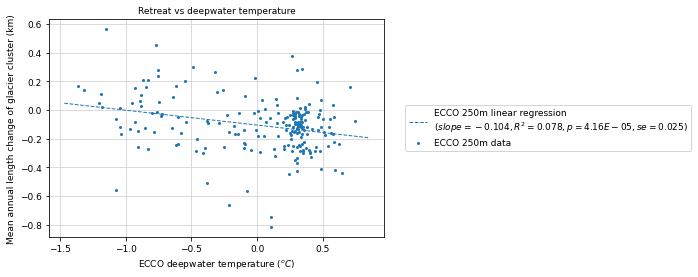

In [16]:
# Retreat vs 250m temperature
x = X['ECCO_depth']

fig, ax = plt.subplots()
plotLinReg(ax, x, Y, dataname='ECCO 250m')
ax.set_xlabel('ECCO deepwater temperature ($^oC$)')
ax.set_ylabel('Mean annual length change of glacier cluster (km)')
ax.set_title('Retreat vs deepwater temperature')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     13.08
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           0.000375
Time:                        16:31:27   Log-Likelihood:                 58.603
No. Observations:                 208   AIC:                            -113.2
Df Residuals:                     206   BIC:                            -106.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1304      0.014     -9.021      0.0

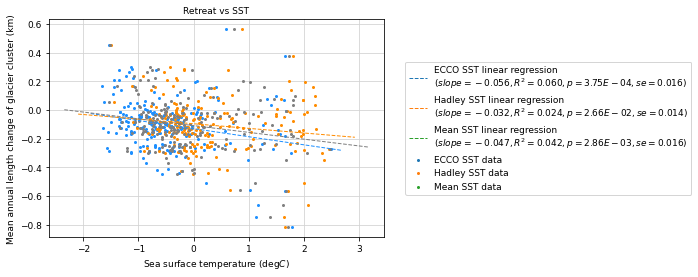

In [17]:
# Retreat vs SST
fig, ax = plt.subplots()

x = X['ECCO_SST']
plotLinReg(ax, x, Y, dataname='ECCO SST')

x = X['Hadley_SST']
plotLinReg(ax, x, Y, dataname='Hadley SST')

x = X['Mean_SST']
plotLinReg(ax, x, Y, dataname='Mean SST')

handles = ax.get_legend_handles_labels()[0]
handles[0].set_color('dodgerblue')
handles[1].set_color('darkorange')
handles[2].set_color('gray')
handles[3].set_color('dodgerblue')
handles[4].set_color('darkorange')
handles[5].set_color('gray')

ax.set_xlabel('Sea surface temperature ($\degC$)')
ax.set_ylabel('Mean annual length change of glacier cluster (km)')
ax.set_title('Retreat vs SST')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.235
Date:                Tue, 21 Sep 2021   Prob (F-statistic):             0.0736
Time:                        16:31:28   Log-Likelihood:                 53.820
No. Observations:                 208   AIC:                            -103.6
Df Residuals:                     206   BIC:                            -96.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0915      0.015     -6.027      0.0

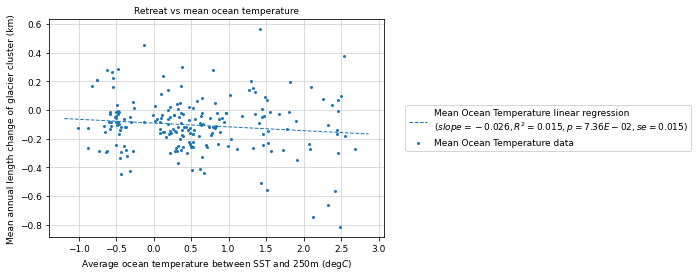

In [18]:
# Retreat vs mean temperature
x = X['Mean_Temp']

fig, ax = plt.subplots()
plotLinReg(ax, x, Y, dataname='Mean Ocean Temperature')
ax.set_xlabel('Average ocean temperature between SST and 250m ($\degC$)')
ax.set_ylabel('Mean annual length change of glacier cluster (km)')
ax.set_title('Retreat vs mean ocean temperature')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.136
Date:                Tue, 21 Sep 2021   Prob (F-statistic):              0.288
Time:                        16:31:28   Log-Likelihood:                 52.772
No. Observations:                 208   AIC:                            -101.5
Df Residuals:                     206   BIC:                            -94.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1728      0.064     -2.681      

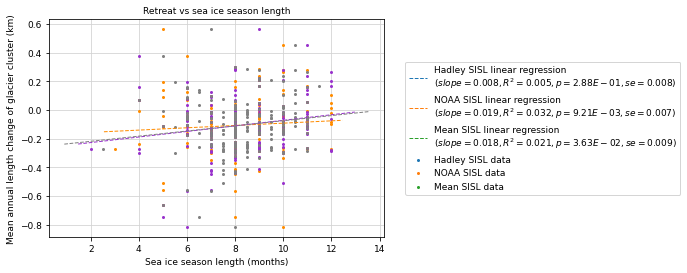

In [19]:
# Retreat vs sea ice season length
fig, ax = plt.subplots()

x = X['Hadley_SISL']
plotLinReg(ax, x, Y, dataname='Hadley SISL')

x = X['NOAA_SISL']
plotLinReg(ax, x, Y, dataname='NOAA SISL')

x = X['Mean_SISL']
plotLinReg(ax, x, Y, dataname='Mean SISL')

handles = ax.get_legend_handles_labels()[0]
handles[0].set_color('darkorange')
handles[1].set_color('darkorchid')
handles[2].set_color('gray')
handles[3].set_color('darkorange')
handles[4].set_color('darkorchid')
handles[5].set_color('gray')

ax.set_xlabel('Sea ice season length (months)')
ax.set_ylabel('Mean annual length change of glacier cluster (km)')
ax.set_title('Retreat vs sea ice season length')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     6.831
Date:                Tue, 21 Sep 2021   Prob (F-statistic):            0.00962
Time:                        16:31:29   Log-Likelihood:                 55.593
No. Observations:                 208   AIC:                            -107.2
Df Residuals:                     206   BIC:                            -100.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2210      0.046     -4.803      

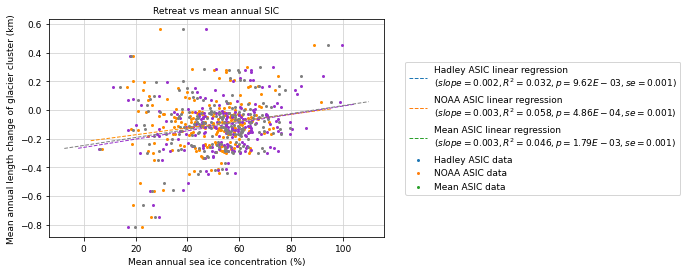

In [20]:
# Retreat vs mean annual sea ice concentration
fig, ax = plt.subplots()

x = X['Hadley_ASIC']
plotLinReg(ax, x, Y, dataname='Hadley ASIC')

x = X['NOAA_ASIC']
plotLinReg(ax, x, Y, dataname='NOAA ASIC')

x = X['Mean_ASIC']
plotLinReg(ax, x, Y, dataname='Mean ASIC')

handles = ax.get_legend_handles_labels()[0]
handles[0].set_color('darkorange')
handles[1].set_color('darkorchid')
handles[2].set_color('gray')
handles[3].set_color('darkorange')
handles[4].set_color('darkorchid')
handles[5].set_color('gray')

ax.set_xlabel('Mean annual sea ice concentration (%)')
ax.set_ylabel('Mean annual length change of glacier cluster (km)')
ax.set_title('Retreat vs mean annual SIC')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     43.18
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           4.02e-10
Time:                        16:31:30   Log-Likelihood:                 71.990
No. Observations:                 208   AIC:                            -140.0
Df Residuals:                     206   BIC:                            -133.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0960      0.012     -7.987      0.0

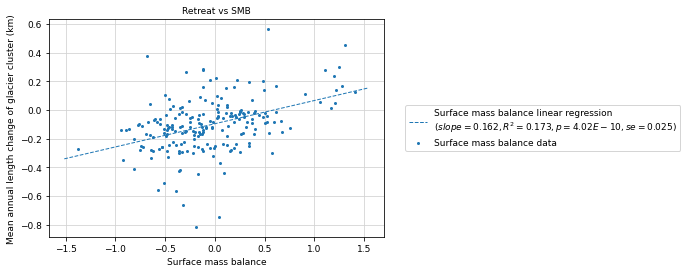

In [21]:
# Retreat vs SMB
x = X['SMB']

fig, ax = plt.subplots()
plotLinReg(ax, x, Y, dataname='Surface mass balance')
ax.set_xlabel('Surface mass balance')
ax.set_ylabel('Mean annual length change of glacier cluster (km)')
ax.set_title('Retreat vs SMB')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.487
Date:                Tue, 21 Sep 2021   Prob (F-statistic):             0.0633
Time:                        16:31:30   Log-Likelihood:                 53.946
No. Observations:                 208   AIC:                            -103.9
Df Residuals:                     206   BIC:                            -97.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1056      0.013     -8.119      0.0

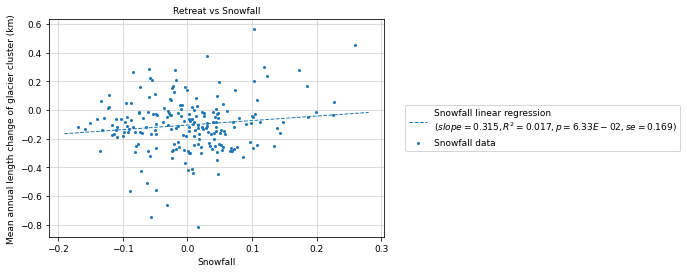

In [22]:
# Retreat vs Snowfall
x = X['Snowfall']

fig, ax = plt.subplots()
plotLinReg(ax, x, Y, dataname='Snowfall')
ax.set_xlabel('Snowfall')
ax.set_ylabel('Mean annual length change of glacier cluster (km)')
ax.set_title('Retreat vs Snowfall')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     46.99
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           8.14e-11
Time:                        16:31:31   Log-Likelihood:                 73.568
No. Observations:                 208   AIC:                            -143.1
Df Residuals:                     206   BIC:                            -136.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0943      0.012     -7.894      0.0

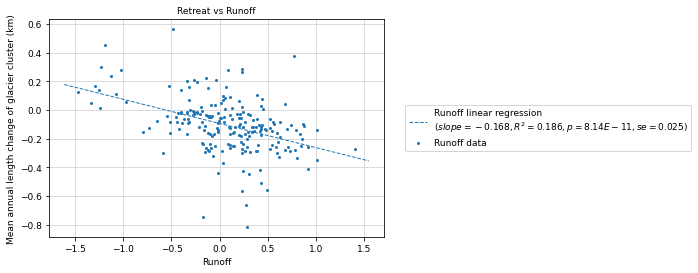

In [23]:
# Retreat vs Runoff
x = X['Runoff']

fig, ax = plt.subplots()
plotLinReg(ax, x, Y, dataname='Runoff')
ax.set_xlabel('Runoff')
ax.set_ylabel('Mean annual length change of glacier cluster (km)')
ax.set_title('Retreat vs Runoff')
plt.show()

## Multiple linear regressions

### Cases 1-3: all available variables

In [24]:
# Case 1: Using dataset means (instead of multiple datasets for each variable)
# -- this is the basis for following cases N.1

x = X[['ECCO_depth', 'Mean_SST', 'Mean_ASIC', 'Mean_SISL', 'Snowfall', 'Runoff']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     8.645
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           2.26e-08
Time:                        16:31:31   Log-Likelihood:                 76.075
No. Observations:                 208   AIC:                            -138.2
Df Residuals:                     201   BIC:                            -114.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0598      0.121      0.495      0.6

### Cases 4.x: Remove sea ice season length (SISL)
because it is correlated with annual sea ice concentration (ASIC)

In [25]:
# Case 4.1: means
x = X[['ECCO_depth', 'Mean_SST', 'Mean_ASIC', 'Snowfall', 'Runoff']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     10.25
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           9.05e-09
Time:                        16:31:31   Log-Likelihood:                 75.716
No. Observations:                 208   AIC:                            -139.4
Df Residuals:                     202   BIC:                            -119.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.100      0.039      0.9

### Cases 5.x: Remove annual sea ice concentration (ASIC)
because it is correlated with SISL

In [26]:
# Case 5.1: means
x = X[['ECCO_depth', 'Mean_SST', 'Mean_SISL', 'Snowfall', 'Runoff']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     10.29
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           8.45e-09
Time:                        16:31:31   Log-Likelihood:                 75.791
No. Observations:                 208   AIC:                            -139.6
Df Residuals:                     202   BIC:                            -119.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.093      0.027      0.9

### Cases 6.x: remove SST
because it is correlated with 250m temperature

In [27]:
# Case 6.1: means
x = X[['ECCO_depth', 'Mean_SISL', 'Mean_ASIC', 'Snowfall', 'Runoff']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     9.843
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           1.95e-08
Time:                        16:31:31   Log-Likelihood:                 74.876
No. Observations:                 208   AIC:                            -137.8
Df Residuals:                     202   BIC:                            -117.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0876      0.073     -1.202      0.2

### Cases 7.x: Remove 250m temperature
because it is correlated with SST

In [28]:
# Case 7.1: means
x = X[['Mean_SST', 'Mean_SISL', 'Mean_ASIC', 'Snowfall', 'Runoff']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     9.922
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           1.68e-08
Time:                        16:31:31   Log-Likelihood:                 75.039
No. Observations:                 208   AIC:                            -138.1
Df Residuals:                     202   BIC:                            -118.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0073      0.115      0.063      0.9

In [29]:
# Case 17: Drop Snowfall

x = X[['ECCO_depth', 'Mean_SST', 'Mean_ASIC', 'Mean_SISL', 'Runoff']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     10.35
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           7.45e-09
Time:                        16:31:31   Log-Likelihood:                 75.929
No. Observations:                 208   AIC:                            -139.9
Df Residuals:                     202   BIC:                            -119.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0513      0.120      0.429      0.6

In [30]:
# Case 18: Drop Runoff

x = X[['ECCO_depth', 'Mean_SST', 'Mean_ASIC', 'Mean_SISL', 'Snowfall']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.825
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           0.000344
Time:                        16:31:32   Log-Likelihood:                 63.932
No. Observations:                 208   AIC:                            -115.9
Df Residuals:                     202   BIC:                            -95.84
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.127     -0.002      0.9

In [31]:
# Case 19: deepwater and SST only

x = X[['ECCO_depth', 'Mean_SST']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     10.63
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           4.04e-05
Time:                        16:31:32   Log-Likelihood:                 62.465
No. Observations:                 208   AIC:                            -118.9
Df Residuals:                     205   BIC:                            -108.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1078      0.013     -8.576      0.0

In [32]:
# Case 20: sea ice only

x = X[['Mean_ASIC', 'Mean_SISL']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     5.016
Date:                Tue, 21 Sep 2021   Prob (F-statistic):            0.00747
Time:                        16:31:32   Log-Likelihood:                 57.168
No. Observations:                 208   AIC:                            -108.3
Df Residuals:                     205   BIC:                            -98.32
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2343      0.072     -3.266      0.0

In [33]:
# Case 21: just runoff

x = X[['Runoff']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     46.99
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           8.14e-11
Time:                        16:31:32   Log-Likelihood:                 73.568
No. Observations:                 208   AIC:                            -143.1
Df Residuals:                     206   BIC:                            -136.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0943      0.012     -7.894      0.0

In [34]:
# Case 22: drop both ocean temperatures
x = X[['Mean_SISL', 'Mean_ASIC', 'Snowfall', 'Runoff']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     11.92
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           1.02e-08
Time:                        16:35:01   Log-Likelihood:                 74.144
No. Observations:                 208   AIC:                            -138.3
Df Residuals:                     203   BIC:                            -121.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1145      0.069     -1.650      0.1

In [35]:
# Case 23: drop both sea ice variables
x = X[['ECCO_depth', 'Mean_SST', 'Snowfall', 'Runoff']]
linreg(x, Y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     12.55
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           3.82e-09
Time:                        16:37:15   Log-Likelihood:                 75.186
No. Observations:                 208   AIC:                            -140.4
Df Residuals:                     203   BIC:                            -123.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0974      0.012     -8.061      0.0